# waypoints

## define agents

In [10]:
class FGAgent:
    def __init__(self, bubble_r=0.5, lookahead_degrees=[90., 270.], speed=2.0):
        self.bubble_r = bubble_r
        self.lookahead_degrees = lookahead_degrees
        self.speed = speed
        
    def get_action(self, state):
        ranges = state[:360]
        #print(ranges[10], ranges[90], ranges[180], ranges[270], ranges[350])
        beg = int(self.lookahead_degrees[0])
        end = int(self.lookahead_degrees[1])

        ranges = ranges[beg:end]

        ranges = np.clip(ranges, 0, 10.0)
        
        nearest_point = np.min(ranges)
        min_dist = nearest_point + self.bubble_r

        ranges = np.where(ranges <= min_dist, 0.0, ranges)

        gaps = []
        if ranges[0] != 0.0:
            gaps.append(0)

        i = 0
        while i < len(ranges):
            if ranges[i] == 0.0:
                if i > 0:
                    gaps.append(i-1)
                while i < len(ranges) and ranges[i] == 0.0:
                    i += 1
                if i < len(ranges):
                    gaps.append(i)
                continue

            i += 1

        if ranges[-1] != 0.0:
            gaps.append(len(ranges) - 1)

        assert len(gaps) % 2 == 0

        max_gap = -1
        gap_beg = 0
        gap_end = 360

        # find max gap
        i = 0
        while i < len(gaps):
            if gaps[i+1]-gaps[i] > max_gap:
                max_gap = gaps[i+1]-gaps[i]
                gap_beg = gaps[i]+beg
                gap_end = gaps[i+1]+beg
            i += 2

        mid_point = float(gap_end+gap_beg)/2.
        angle_deg = mid_point - 180
        angle_rad = angle_deg * (np.pi/180.)
#         print(f"midpoint:{mid_point}")
        angle = angle_rad * 1.0
        return [angle, self.speed]



In [13]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class WPEnv(gym.Env):
    
    def __init__(self, map_name='', begin_pos=None):
        self.map_name = map_name
        self.begin_pos = begin_pos
        self.reset()
        
  
    def reset(self):
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_path = f"../maps/{self.map_name}"
        
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(render_callback)
        
        begin_pos = [0, 0, 0] if self.begin_pos is None else self.begin_pos
        obs, step_reward, done, info = self.env.reset(np.array([begin_pos]))
 
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, 10)
        buck = 3
        size = 1080//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.mean(scanner[i*buck: i*buck+buck])
                
        state = [
            agg_scanner,
            np.array(obs['linear_vels_x'][0]),
            np.array(obs['ang_vels_z'][0]),
            (obs['poses_x'][0], obs['poses_y'][0], obs['poses_theta'][0])
        ]

        return state
    
        
    def step(self, action):
        act = np.array([action])
        reward = 0
        obs, step_reward, done, info = self.env.step(act)
        
        if obs['collisions'][0] == 1.0:
            print("CRASHED")
            done = True
            reward = -1
        
                
        if obs['lap_counts'][0] == 1.0:
            reward = 1.0
            print("DONE")
            done = True
        
        next_state = self.to_vector_state(obs)
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

WPEnv(map_name='Oschersleben1')

## create waypoints

In [16]:

done = False
env = WPEnv(map_name='Oschersleben2', begin_pos=[0.0702245, 0.3002981, 2.79787])
obs = env.reset()
agent = FGAgent(speed=2.0)

positions = []

while not done:
    positions.append(obs[3])
    th, v = agent.get_action(obs[0])
    obs, r, done, _ = env.step([th, v])
#     env.render()

DONE


In [21]:
with open('../maps/Oschersleben2-wp.np', 'wb') as f:
    np.save(f, positions)

## analyze waypoints

In [25]:
import numpy as np

with open('../maps/Oschersleben2-wp.np', 'rb') as f:
    wps = np.load(f)
    
dist = np.linalg.norm(wps[0][:2] - wps[117][:2])
print(dist)
print(len(wps))
print(len(wps)//110)

1.8980915183812395
12949
117


In [26]:
from tqdm import tqdm
import gym

map_name = 'Oschersleben2'
env = gym.make('f110_gym:f110-v0', map=f"../maps/{map_name}", map_ext='.png', num_agents=1)

for wp in tqdm(wps):
    obs, step_reward, done, info = env.reset(
        np.array([
            wp
        ])
    )
    if min(obs['scans'][0]) < 0.3:
        print(min(obs['scans'][0]))
        

100%|██████████| 12949/12949 [00:05<00:00, 2254.32it/s]


In [27]:
from scipy.spatial.distance import cdist

x = cdist([[0,0]], wps[:,:2])
np.argmin(x)

12948

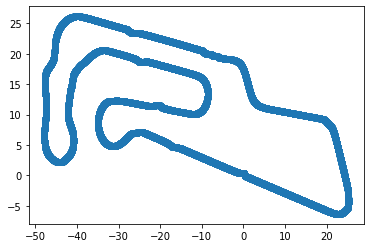

In [28]:
import matplotlib.pyplot as plt

plt.scatter(wps[:,0], wps[:, 1])

# environment

In [5]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from scipy.spatial.distance import cdist


class F110RaceEnv(gym.Env):
    def __init__(self, env_config,
                 test_map_name=None,
                 scan_range=10.0,
                 max_v=20.0,
                 n_cps = 110,
                 cp_reward = 0.05,
                 min_cp_dist=3.0,
                 maps_path='../maps',
                 models_path='../checkpoints',
                 train_map_name='Oschersleben',
                 safe_padding=0.3,
                 laps = 1.0,
                 min_deg=80,
                 max_deg=280,
                 begin_pos=[0.0702245, 0.3002981, 2.79787]
                ):
        
        self.laps = laps
        self.maps_path = maps_path
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(202,), dtype=np.float32)
        self.max_v = max_v
        self.test_map_name = test_map_name
        self.min_cp_dist = min_cp_dist
        self.n_cps = n_cps
        self.cp_reward = cp_reward
        self.scan_range = scan_range
        self.safe_padding = safe_padding
        self.map_path = None
        self.train_map_name = train_map_name
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.cum_r = 0
        self.prev_vel = [4.0] * 100
        self.total_padding_punish = 0
        self.min_deg = min_deg
        self.max_deg = max_deg
        self.begin_pos = begin_pos
    
    def _render_callback(self, env_renderer):
        # custom extra drawing function

        e = env_renderer

        # update camera to follow car
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800
  
    def load_train_setup(self):
        no = np.random.choice([1, 2])
        
        map_path = f"{self.maps_path}/{self.train_map_name}{no}"
        with open(f'{self.maps_path}/Oschersleben{no}-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps
    
    def load_test_setup(self):
        map_path = f"{self.maps_path}/{self.test_map_name}"
        with open(f'{self.maps_path}/Oschersleben1-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps

    def build_checkpoints(self, wps, cp_dist):
        
        start = np.random.randint(0, len(wps)-1)
        checkpoints = []
        
        i = 0
        while i < len(wps):
            if i % cp_dist == 0:
                checkpoints.append(wps[(start+i)%len(wps)])
            i += 1
        return checkpoints
    
    def reset(self):
        self.prev_vel = [3.0] * 100
        self.total_padding_punish = 0
        self.cum_r = 0
        
        if self.test_map_name is not None:
            map_path, wps = self.load_test_setup()
        else:
            map_path, wps = self.load_train_setup()
        
#         print(map_path, len(wps))
        self.map_path = map_path
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(self._render_callback)
        
        cp_dist = len(wps)//self.n_cps
        
        self.checkpoints = self.build_checkpoints(wps, cp_dist)
#         print(f"number of checkpoints: {len(self.checkpoints)}")
        
        if self.test_map_name is None:
            start_idx = np.random.randint(0, len(self.checkpoints))
            start_point = self.checkpoints[start_idx]
            
        else:
            dists = cdist([self.begin_pos[:2]], np.array(self.checkpoints)[:,:2])
            start_idx = np.argmin(dists)
            start_point = self.begin_pos
            
        self.next_cp_idx = (start_idx + 2)%len(self.checkpoints)
            
        
        obs, step_reward, done, info = self.env.reset(
            np.array([
                start_point
            ])
        )
        
        self.t = 0

        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        ranges = obs['scans'][0]
        ranges = ranges[int((self.min_deg/360)*len(ranges)):int((self.max_deg/360)*len(ranges))]
        scanner = np.clip(ranges, 0, self.scan_range)
        
        buck = 3
        size = len(scanner)//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.min(scanner[i*buck: i*buck+buck])
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/self.max_v,
        ])
        
        if self.test_map_name is None:
            noise = np.random.normal(loc=0.0, scale=0.02, size=state.shape)
            state = state + noise
        
        return state
    
    def checkpoint(self, position):
        return_cp_idx = (self.next_cp_idx - 5)%len(self.checkpoints)
        return_dist = np.linalg.norm(position - self.checkpoints[return_cp_idx][:2])
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        elif return_dist < 3.0:
            reward = -1
        return reward
        
        
    def step(self, action):
        reward = 0

        act_v = action[0]*(self.max_v/2)+(self.max_v/2)
        self.prev_vel.insert(0, act_v)
        self.prev_vel.pop()
        
        
        th = action[1]*np.pi/6
        act = np.array([[th, act_v]])

        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        next_state = self.to_vector_state(obs)
        position = np.array([pose_x, pose_y])

        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            #if self.test_map_name is not None:
                #print('CRASHED')
            return next_state, reward, done, {}
            
        cp_reward = self.checkpoint(position)
        reward += cp_reward
        self.t += 1
        
        finish_time = 100
        if obs['lap_counts'][0] == self.laps:
            t = obs['lap_times'][0]  
#             reward = np.exp(2.5 - 0.05*t)
            finish_time = t
            fairlap = 30
            reward = max(0.2*(fairlap - t), self.cp_reward)
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. Finish reward: {reward}. Padding punish: {self.total_padding_punish}")
            done = True
        elif cp_reward == -1:
            t = obs['lap_times'][0]
            #print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. RETURNED")
            done = True
        elif np.max(self.prev_vel)<3.0:
            t = obs['lap_times'][0]
            #print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. STOPPED")
            reward = -1
            done = True
        
        if done and self.test_map_name is not None:
            print('lap:', obs['lap_times'])
        
#         if np.min(obs['scans'][0]) < self.safe_padding:
#             reward += -0.05
#             self.total_padding_punish -= 0.05
        
        self.cum_r += reward
        return next_state, reward, done, {'pos': position, 'finish_time': finish_time}
    
    def render(self):
        self.env.render()

e = F110RaceEnv({})
e.reset().shape

(202,)

# training

In [6]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [7]:
%%time

import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()



# with half cheeta configs

hc_configs = {
    'framework': 'torch',
    'num_workers': 15,
    'gamma': 0.99,
    'num_gpus': 1.0,
    'kl_coeff': 1.0,
    'clip_param': 0.2,
    'model': {
        'fcnet_hiddens': [300, 300],
    },
    'num_envs_per_worker': 1,
    'train_batch_size': 100000,
    'sgd_minibatch_size': 4096,
    'batch_mode': 'truncate_episodes',
    'lr': .0003,
}


trainer = ppo.PPOTrainer(env=F110RaceEnv, config=hc_configs)
# print("FINE TUNING")
#trainer.restore('../checkpoints/sim_v1.0.2/checkpoint_000071/checkpoint-71')

print(trainer.config)
rewards = []
eval_rewards = []
best_reward = -100
models_path = '../checkpoints'

import pickle

def evaluate(model, envs, k=6):
    avg_r = []
    for i in range(k):
        env = envs[i%len(envs)]
        done = False
        obs = env.reset()

        r = 0
        while not done:
            action = model.compute_single_action(obs, explore=False)
            obs, reward, done, info = env.step(action)
            r += reward

        avg_r.append(r)
        
    return np.mean(avg_r)


eval_envs = [
    F110RaceEnv({}, test_map_name='Oschersleben_test2', laps=1),
    F110RaceEnv({}, test_map_name='Oschersleben_test1', laps=1),
]

sim_name = 'sim_v1.0.7'

for i in range(300):
    result = trainer.train()
    episode_r = result['episode_reward_mean']
    print(f"episode: {i} reward:{episode_r}")
    rewards.append(episode_r)
    with open(f'{models_path}/{sim_name}_r', 'wb') as f:
        pickle.dump(rewards, f)
        
    if i%5 == 0:
        eval_reward = evaluate(trainer, envs=eval_envs)
        print(f"evaluation reward: {eval_reward}")
        eval_rewards.append(eval_reward)
        with open(f'{models_path}/{sim_name}_er', 'wb') as f:
            pickle.dump(eval_rewards, f)
        if eval_reward > best_reward:
            best_reward = episode_r
            cp = trainer.save(f"{models_path}/{sim_name}")
            print("checkpoint saved at", cp)


2022-05-01 19:46:25,008	WARNING ppo.py:223 -- `train_batch_size` (100000) cannot be achieved with your other settings (num_workers=15 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 6666.
2022-05-01 19:46:25,009	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-05-01 19:46:25,010	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=23608) 2022-05-01 19:46:33,234	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=23610) 2022-05-01 19:46:33,298	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVecto

{'num_workers': 15, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 6666, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 0.0003, 'train_batch_size': 100000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [300, 300], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_use_n_

episode: 0 reward:-0.9314506172839505


2022-05-01 19:48:05,805	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


evaluation reward: -0.39999999999999997
checkpoint saved at ../checkpoints/sim_v1.0.7/checkpoint_000001/checkpoint-1
episode: 1 reward:-0.9203052422030523
episode: 2 reward:-0.8932235834609497
episode: 3 reward:-0.8467575187969926
episode: 4 reward:-0.7854534746760895
episode: 5 reward:-0.7078055964653903
evaluation reward: -0.3083333333333333
checkpoint saved at ../checkpoints/sim_v1.0.7/checkpoint_000006/checkpoint-6
episode: 6 reward:-0.6686385737439221
episode: 7 reward:-0.6049348230912477
episode: 8 reward:-0.49259259259259247
episode: 9 reward:-0.4550351288056205
episode: 10 reward:-0.32393162393162384
agent on ../maps/Oschersleben_test2 got reward 5.549999999999988 in 38.76000000000086. Finish reward: 0.05. Padding punish: 0
lap: [38.76]
agent on ../maps/Oschersleben_test2 got reward 5.4999999999999885 in 38.76000000000086. Finish reward: 0.05. Padding punish: 0
lap: [38.76]
agent on ../maps/Oschersleben_test2 got reward 5.4999999999999885 in 38.76000000000086. Finish reward: 0.

episode: 21 reward:1.4087962962962939
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 45.71999999999947. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 43.5899999999999. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 43.93999999999983. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 42.690000000000076. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 43.28999999999996. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23610) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 41.91000000000023. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.5499999999

(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 42.700000000000074. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 44.149999999999785. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 43.95999999999982. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 45.16999999999958. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 42.78000000000006. Finish reward: 0.05. Padding punish: 0
episode: 26 reward:1.7949999999999968
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 43.01000000000001. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23610) agent on ../maps/Oschersleben2 got reward 5.54999999

(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 44.17999999999978. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 41.51000000000031. Finish reward: 0.05. Padding punish: 0
episode: 29 reward:1.8954999999999964
(RolloutWorker pid=23617) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 43.189999999999976. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 41.96000000000022. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 44.13999999999979. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 42.76000000000006. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999

(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 41.26000000000036. Finish reward: 0.05. Padding punish: 0
episode: 32 reward:1.9014999999999964
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 40.21000000000057. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 41.51000000000031. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 41.130000000000386. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 40.76000000000046. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 40.080000000000595. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.54999999

(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.93000000000102. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.85000000000104. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.470000000000915. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.66000000000088. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.620000000000886. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.23000000000116. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.99000000000101. Finish r

(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.66000000000108. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.64000000000088. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.08000000000099. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 39.51000000000071. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.73000000000126. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.970000000001015. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.50000000000091. Finish re

(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.45000000000112. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.49000000000111. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.68000000000107. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.75000000000086. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.120000000000985. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.420000000001124. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.45000000000092. Finish r

episode: 43 reward:1.7923423423423392
(RolloutWorker pid=23610) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.830000000000844. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.27000000000135. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.15000000000118. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.24000000000116. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.40000000000113. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 39.020000000000806. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben1 got reward 5.54999999

evaluation reward: 2.8333333333333273
checkpoint saved at ../checkpoints/sim_v1.0.7/checkpoint_000046/checkpoint-46
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 39.130000000000784. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.050000000001. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.820000000001045. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.720000000000866. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.5300000000009. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.43000000000092. Finish reward: 0.05. Padding punish: 0
(R

(RolloutWorker pid=23599) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 41.180000000000376. Finish reward: 0.05. Padding punish: 0
episode: 47 reward:2.8254999999999946
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.620000000000886. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 39.680000000000675. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 40.930000000000426. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 39.99000000000061. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 39.86000000000064. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999

(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.39000000000093. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.65000000000088. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 39.5600000000007. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.79000000000085. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.71000000000107. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.40000000000113. Finish reward: 0.05. Padding punish: 0
episode: 49 reward:2.870499999999994
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999

(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 39.96000000000062. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 40.230000000000565. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 40.66000000000048. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 40.71000000000047. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 40.91000000000043. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 39.00000000000081. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 40.37000000000054. Finish re

(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 39.35000000000074. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 40.730000000000466. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23610) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.050000000001. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 39.09000000000079. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 39.5400000000007. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 40.690000000000474. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 39.59000000000069. Finish rewa

(RolloutWorker pid=23615) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.70000000000087. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.75000000000086. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.26000000000096. Finish reward: 0.05. Padding punish: 0
episode: 54 reward:3.332999999999992
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.19000000000117. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.19000000000097. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23610) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 39.11000000000079. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.54999999999

(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.23000000000136. Finish reward: 0.05. Padding punish: 0
episode: 56 reward:2.046116504854365
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.210000000001365. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.00000000000121. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.88000000000123. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.09000000000139. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.20000000000117. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.5499999999

(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.69000000000147. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.33000000000154. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23610) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.5200000000013. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.33000000000134. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.98000000000161. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.900000000001626. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.12000000000138. Finish rew

(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.700000000001864. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.58000000000169. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.66000000000187. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 35.100000000001586. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.89000000000163. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.81000000000184. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.46000000000171. Finish r

(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.83000000000164. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.800000000001646. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.79000000000185. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 35.250000000001556. Finish reward: 0.05. Padding punish: 0
episode: 63 reward:2.138571428571425
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.29000000000155. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.09000000000179. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben1 got reward 5.549999999

agent on ../maps/Oschersleben_test2 got reward 5.549999999999988 in 33.74000000000186. Finish reward: 0.05. Padding punish: 0
lap: [33.74]
evaluation reward: 2.7249999999999943
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.69000000000167. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.28000000000155. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.700000000001666. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.59000000000169. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.000000000001606. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 

(RolloutWorker pid=23610) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.27000000000155. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 36.0500000000014. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.610000000001484. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.56000000000169. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.910000000001624. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.34000000000154. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 35.250000000001556. Finish r

(RolloutWorker pid=23599) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.35000000000114. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben1 got reward 5.4999999999999885 in 37.09000000000119. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.5300000000015. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.45000000000132. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 36.29000000000135. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.17000000000157. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.700000000001666. Finish re

(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.92000000000142. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.69000000000167. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.5300000000017. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.97000000000141. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23610) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.45000000000092. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 35.93000000000142. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.250000000001556. Finish rew

(RolloutWorker pid=23586) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 36.010000000001405. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 35.0200000000016. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 36.45000000000132. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.400000000001725. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.17000000000157. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.34000000000154. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.24000000000156. Finish re

(RolloutWorker pid=23623) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.620000000001085. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 36.660000000001276. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.30000000000135. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.31000000000174. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.07000000000139. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.28000000000115. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.060000000001395. Finish 

(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.34000000000154. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.67000000000147. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.57000000000149. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.62000000000148. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.34000000000114. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.88000000000143. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.410000000001126. Finish re

(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.510000000001305. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.33000000000114. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.870000000001234. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.73000000000126. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.83000000000124. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.73000000000106. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.83000000000144. Finish r

agent on ../maps/Oschersleben_test2 got reward 5.4999999999999885 in 35.60000000000149. Finish reward: 0.05. Padding punish: 0
lap: [35.6]
evaluation reward: 2.8333333333333273
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.260000000001355. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.43000000000112. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.18000000000137. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.43000000000092. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.14000000000118. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 i

(RolloutWorker pid=23622) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.110000000001186. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.84000000000124. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.5400000000011. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.810000000001246. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.0400000000014. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.47000000000131. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.170000000001174. Finish re

(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.65000000000128. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.99000000000141. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.910000000001425. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.960000000001415. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.120000000001184. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.070000000001194. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.210000000001166. Finis

(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.94000000000122. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.44000000000092. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.59000000000089. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23610) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.34000000000114. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.39000000000113. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.92000000000142. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.78000000000105. Finish rew

episode: 86 reward:3.408499999999993
(RolloutWorker pid=23617) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 39.070000000000796. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.870000000001035. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 39.26000000000076. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.20000000000137. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.84000000000104. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.47000000000131. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben1 got reward 5.549999999

(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.970000000001214. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23610) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.110000000001186. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.34000000000134. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.86000000000084. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.25000000000116. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 39.5500000000007. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.34000000000134. Finish re

(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.20000000000117. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.95000000000122. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23610) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.69000000000107. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 38.120000000000985. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.120000000001184. Finish reward: 0.05. Padding punish: 0
episode: 89 reward:3.7479999999999922
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.28000000000135. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben1 got reward 5.54999999

agent on ../maps/Oschersleben_test1 got reward 5.549999999999988 in 37.670000000001075. Finish reward: 0.05. Padding punish: 0
lap: [37.67]
evaluation reward: 5.5833333333333215
checkpoint saved at ../checkpoints/sim_v1.0.7/checkpoint_000091/checkpoint-91
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.66000000000108. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.28000000000135. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.610000000001286. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.68000000000127. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.760000000001256. Finish reward: 0.05. Padding punish: 0
(Rollou

(RolloutWorker pid=23611) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 40.590000000000494. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.99000000000141. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.110000000001186. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.0300000000012. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.35000000000094. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.980000000000814. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.010000000001206. Finish 

(RolloutWorker pid=23587) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 39.130000000000784. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.870000000001234. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.5400000000009. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.410000000001325. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.32000000000134. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.09000000000119. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.0400000000012. Finish re

(RolloutWorker pid=23611) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.19000000000097. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.74000000000086. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.95000000000142. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.28000000000095. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.630000000000884. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.81000000000085. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.98000000000121. Finish re

(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.360000000001335. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 36.660000000001276. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.78000000000105. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.560000000001494. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.860000000001435. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.07000000000139. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.28000000000135. Finish

(RolloutWorker pid=23612) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.19000000000097. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23610) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 39.120000000000786. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 39.070000000000796. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.680000000000874. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.66000000000088. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 39.030000000000804. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.870000000000836. Finis

(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.28000000000115. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.820000000000846. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.720000000001065. Finish reward: 0.05. Padding punish: 0
episode: 99 reward:2.8684999999999934
(RolloutWorker pid=23609) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 40.01000000000061. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.0200000000014. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23610) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.24000000000116. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999

(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.860000000001435. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.160000000001574. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.820000000001244. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.350000000001536. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.260000000001355. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.90000000000143. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.84000000000124. Finis

(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.5300000000013. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.19000000000137. Finish reward: 0.05. Padding punish: 0
episode: 102 reward:2.8034999999999934
(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.710000000001465. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.84000000000144. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.920000000001025. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23610) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.5400000000015. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben1 got reward 5.549999999

(RolloutWorker pid=23595) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 36.010000000001405. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.84000000000184. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.5300000000019. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.69000000000167. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.82000000000184. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.000000000001805. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.300000000001944. Finish r

(RolloutWorker pid=23618) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 35.12000000000158. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.44000000000172. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.91000000000182. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.390000000001926. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.300000000001745. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.89000000000183. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.48000000000171. Finish r

(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.81000000000184. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.47000000000171. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.09000000000179. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.98000000000181. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 35.72000000000146. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.97000000000181. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.31000000000194. Finish rew

(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.43000000000132. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 36.42000000000132. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.5100000000017. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.610000000001484. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.23000000000156. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.22000000000176. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.41000000000172. Finish rew

(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.38000000000153. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23610) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.24000000000176. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.47000000000171. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.500000000001705. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.14000000000158. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.900000000001825. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.0500000000014. Finish re

(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.600000000001884. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.07000000000179. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.97000000000181. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.97000000000181. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.800000000001646. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.94000000000162. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.78000000000165. Finish r

(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.31000000000174. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.66000000000187. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.63000000000148. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 36.45000000000132. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.17000000000177. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.68000000000167. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.450000000001715. Finish re

(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.32000000000174. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.92000000000182. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 36.310000000001345. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 36.00000000000141. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 35.83000000000144. Finish reward: 0.05. Padding punish: 0
episode: 118 reward:1.6182170542635628
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.12000000000178. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.54999999

(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.5200000000017. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 36.160000000001375. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.24000000000176. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.000000000001805. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.48000000000191. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.68000000000187. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 33.56000000000189. Finish re

episode: 123 reward:1.8656521739130398
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.900000000001626. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.12000000000138. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.5100000000017. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.63000000000168. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.360000000001136. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.050000000001596. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23587) agent on ../maps/Oschersleben2 got reward 5.5499999

(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.15000000000138. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.67000000000147. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.78000000000145. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.58000000000149. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23595) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 34.37000000000173. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.42000000000132. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.94000000000142. Finish rew

(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.23000000000136. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.400000000001526. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.33000000000154. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23586) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 39.16000000000078. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.37000000000153. Finish reward: 0.05. Padding punish: 0
episode: 127 reward:2.344999999999995
(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.64000000000148. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben1 got reward 5.549999999

(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.33000000000154. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 37.93000000000102. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.17000000000137. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23615) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.760000000001455. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.78000000000145. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.82000000000144. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.69000000000147. Finish re

(RolloutWorker pid=23618) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.5400000000013. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.23000000000136. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23623) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.57000000000129. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23611) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.30000000000135. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.17000000000137. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.610000000001484. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.40000000000133. Finish rew

(RolloutWorker pid=23611) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 39.380000000000734. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.24000000000136. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23609) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.610000000001286. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.45000000000132. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23612) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.460000000001514. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.67000000000147. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 36.47000000000131. Finish 

(RolloutWorker pid=23620) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.09000000000119. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.5300000000009. Finish reward: 0.05. Padding punish: 0
episode: 135 reward:2.4984999999999946
agent on ../maps/Oschersleben_test2 got reward 5.4999999999999885 in 35.27000000000155. Finish reward: 0.05. Padding punish: 0
lap: [35.27]
agent on ../maps/Oschersleben_test2 got reward 5.549999999999988 in 35.27000000000155. Finish reward: 0.05. Padding punish: 0
lap: [35.27]
agent on ../maps/Oschersleben_test2 got reward 5.549999999999988 in 35.27000000000155. Finish reward: 0.05. Padding punish: 0
lap: [35.27]
evaluation reward: 2.5833333333333273
(RolloutWorker pid=23608) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 39.680000000000675. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23610) agent on ../maps/Oschersleben2 got rew

(RolloutWorker pid=23615) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 40.32000000000055. Finish reward: 0.05. Padding punish: 0
episode: 137 reward:2.6059999999999945
(RolloutWorker pid=23586) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 35.310000000001544. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23608) agent on ../maps/Oschersleben2 got reward 5.549999999999988 in 37.34000000000114. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23599) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 39.21000000000077. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23618) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 39.60000000000069. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23622) agent on ../maps/Oschersleben1 got reward 5.549999999999988 in 38.870000000000836. Finish reward: 0.05. Padding punish: 0
(RolloutWorker pid=23617) agent on ../maps/Oschersleben2 got reward 5.5499999

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1324, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 68, in <module>
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/tune/trainable.py", line 315, in train
    result = self.step()
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/rllib/agents/trainer.py", line 963, in step
    step_attempt_results = self.step_attempt()
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/rllib/agents/trainer.py", line 1042, in step_attempt
    step_results = self._exec_plan_or_training_iteration_fn()
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/rllib/agents/trainer.py", line 1962, in _exec_plan_or_training_iteration_fn
    results = next(self.train

TypeError: object of type 'NoneType' has no len()

In [9]:
#!rm -rf ../checkpoints/sim_v1.0.5/

## evaluation

In [33]:
import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [300, 300]
DEFAULT_CONFIG["evaluation_num_workers"] = 0
DEFAULT_CONFIG["evaluation_config"]["render_env"] = False
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
DEFAULT_CONFIG['explore'] = False

trainer = ppo.PPOTrainer(env=F110RaceEnv, config=DEFAULT_CONFIG)
trainer.restore('../checkpoints/sim_v1.0.7/checkpoint_000111/checkpoint-111')



2022-05-02 01:00:04,351	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-05-02 01:00:04,376	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/sim_v1.0.7/checkpoint_000111/checkpoint-111
2022-05-02 01:00:04,377	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 111, '_timesteps_total': 22197780, '_time_total': 5716.270320892334, '_episodes_total': 33401}


In [36]:
done = False
env = F110RaceEnv({}, test_map_name='Oschersleben_test1', laps=2)
obs = env.reset()
poses = []
hist = []

r = 0
i = 0
while not done:
    i += 1
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, info = env.step(action)
    if 'pos' in info:
        pos = info['pos'] 
        hist.append([obs[-2], reward, done, pos])
    
    if i % 100 == 0 and len(pos)>0:
        poses.append(pos)
    r += reward
    
print(f'reward:{r}')
env.close()

# hist

reward:-0.4


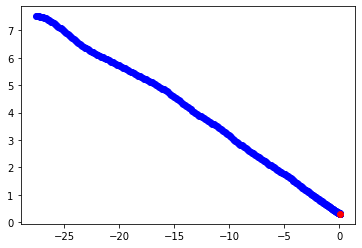

In [37]:
import matplotlib.pyplot as plt

wps = np.array([i[-1] for i in hist])
plt.scatter(wps[:,0], wps[:,1], c='b')
plt.scatter(wps[0,0], wps[0,1], c='r')

## Exporting models

In [ ]:
import torch

policy_model = trainer.get_policy().model
policy_model_hiddens = policy_model._hidden_layers
policy_model_logits = policy_model._logits
policy_model_hiddens

In [ ]:
policy_path = '../checkpoints/phy_1.0.5.pt'
torch.save({
    'h1': policy_model_hiddens[0]._model.state_dict(),
    'h2': policy_model_hiddens[1]._model.state_dict(),
    'logits': policy_model_logits._model.state_dict()
}, policy_path)

In [ ]:
class Policy(torch.nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        
        self.h1 = torch.nn.Sequential(
                torch.nn.Linear(in_features=182, out_features=300, bias=True),
                torch.nn.Tanh()
            )
        self.h2 = torch.nn.Sequential(
            torch.nn.Linear(in_features=300, out_features=300, bias=True),
            torch.nn.Tanh()
        )
        
        self.logits =  torch.nn.Sequential(
            torch.nn.Linear(in_features=300, out_features=4, bias=True),
        )
        
    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.logits(x)

exported_policy = Policy()
exported_policy.h1.load_state_dict(torch.load(policy_path)['h1'])
exported_policy.h2.load_state_dict(torch.load(policy_path)['h2'])
exported_policy.logits.load_state_dict(torch.load(policy_path)['logits'])
exported_policy.eval()

In [ ]:
done = False
env = F110RaceEnv({}, test_map_name='Oschersleben1')
obs = env.reset()
poses = []
hist = []

r = 0
i = 0
while not done:
    i += 1
    obs_t = torch.tensor(obs, dtype=torch.float32)
    output = exported_policy(obs_t).detach().numpy()
    v = output[0]
    th = output[1]
#     v = np.clip(v, -1, 1)
#     th = np.clip(th, -1, 1)
    obs, reward, done, info = env.step([v, th])
#     print(obs[-2:])
    if 'pos' in info:
        pos = info['pos'] 
        hist.append([obs[-2], reward, done, pos])
    
    if i % 100 == 0 and len(pos)>0:
        poses.append(pos)
    r += reward
    env.render()
print(f'reward:{r}')
env.close()

# hist

## Reward plots

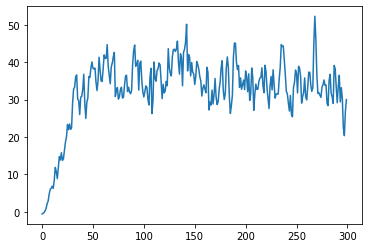

In [44]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/race_v1.1_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

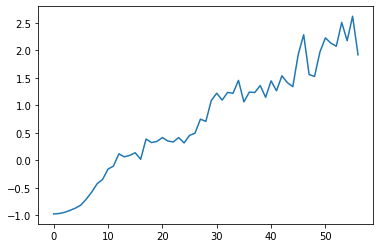

In [40]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/sim_v1.0.8_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

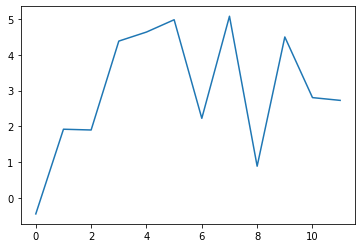

In [41]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/sim_v1.0.8_er', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)
